In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *

## Data

In [ ]:
PATH = Path('../../data/coco')
ANNOT_PATH = PATH/'annotations'

In [ ]:
train_ds = ObjectDetectDataset.from_json(PATH/'train2017', ANNOT_PATH/'train_sample.json')

In [ ]:
tfms = get_transforms()
train_tds = DatasetTfm(train_ds, tfms[0], tfm_y=True, size=224)

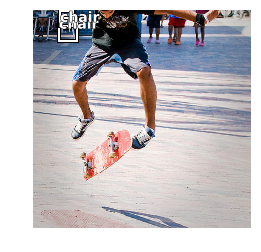

In [ ]:
x,y = train_tds[5]
x.show(y=y, classes=train_ds.classes, figsize=(6,4))

In [ ]:
size = 224

In [ ]:
tfms = ([flip_lr(p=0.5), crop_pad(size=size)], [crop_pad(size=size)])
train_tds = DatasetTfm(train_ds, tfms[0], tfm_y=True, size=size, padding_mode='zeros', do_crop=False)

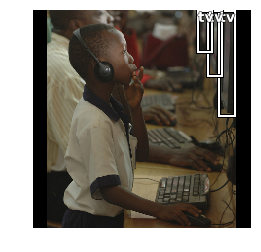

In [ ]:
x,y = train_tds[0]
x.show(y=y, classes=train_ds.classes, figsize=(6,4))

In [ ]:
y.data

(tensor([[-1.0000,  0.7054, -0.0357,  0.8482],
         [-1.0000,  0.5982, -0.4018,  0.7321],
         [-1.0000,  0.5089, -0.6250,  0.6429]]), tensor([1, 1, 1]))

In [ ]:
x.size

torch.Size([224, 224])

In [ ]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0, pad_first:bool=True) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect samples and adds padding."
    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples): 
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = lbls
    return torch.cat(imgs,0), (bboxes,labels)

In [ ]:
train_dl = DataLoader(train_tds, 64, shuffle=False, collate_fn=bb_pad_collate)

In [ ]:
def show_sample(dl, rows, start=0):
    x,y = next(iter(dl))
    x = x[start:start+rows*rows].cpu()
    _,axs = plt.subplots(rows,rows,figsize=(9,9))
    for i, ax in enumerate(axs.flatten()):
        img = Image(x[i])
        idxs = y[1][start+i].nonzero()[:,0]
        if len(idxs) != 0:
            bbs,lbls = y[0][start+i][idxs],y[1][start+i][idxs]
            h,w = img.size
            bbs = ((bbs+1) * torch.tensor([h/2,w/2, h/2, w/2])).long()
            bbox = ImageBBox.create(bbs, *img.size, lbls)
            img.show(ax=ax, y=bbox, classes=dl.dataset.classes)
        else: img.show(ax=ax)
    plt.tight_layout()

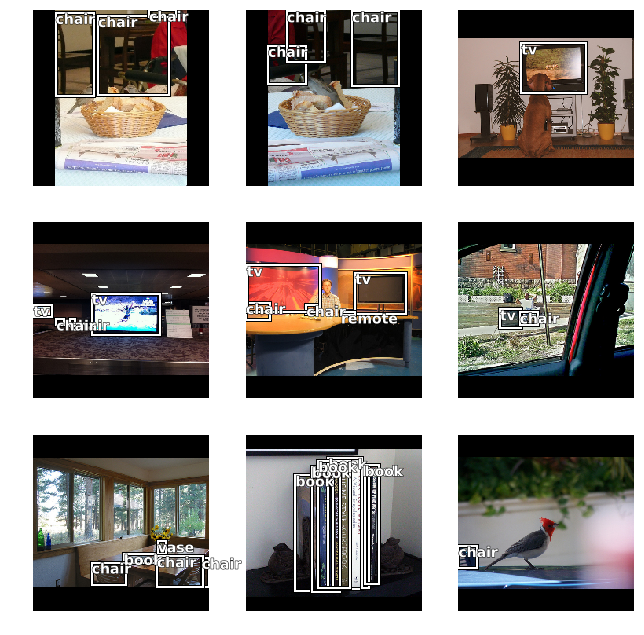

In [ ]:
show_sample(train_dl, 3, 18)

In [ ]:
train_ds, valid_ds = ObjectDetectDataset.from_json(PATH/'train2017', ANNOT_PATH/'train_sample.json', valid_pct=0.2)
data = DataBunch.create(train_ds, valid_ds, path=PATH, ds_tfms=tfms, tfms=imagenet_norm, collate_fn=bb_pad_collate, 
                        num_workers=8, bs=16, size=128, tfm_y=True, padding_mode='zeros', do_crop=False)

In [ ]:
def show_sample(dl, rows, denorm=None):
    x,y = next(iter(dl))
    x = x[:rows*rows].cpu()
    if denorm: x = denorm(x)
    _,axs = plt.subplots(rows,rows,figsize=(9,9))
    for i, ax in enumerate(axs.flatten()):
        img = Image(x[i])
        idxs = y[1][i].nonzero()[:,0]
        if len(idxs) != 0:
            bbs,lbls = y[0][i][idxs],y[1][i][idxs]
            h,w = img.size
            bbs = ((bbs.cpu()+1) * torch.tensor([h/2,w/2, h/2, w/2])).long()
            bbox = ImageBBox.create(bbs, *img.size, lbls)
            img.show(ax=ax, y=bbox, classes=dl.dataset.classes)
        else: img.show(ax=ax)
    plt.tight_layout()

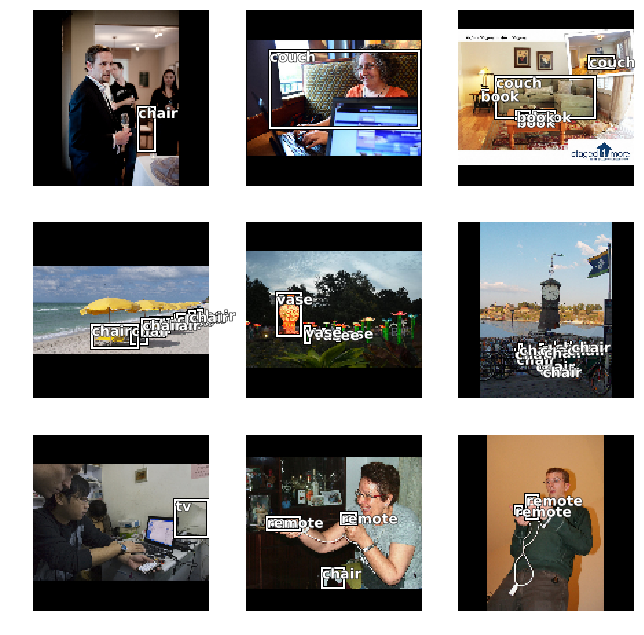

In [ ]:
show_sample(data.train_dl, 3, denorm=imagenet_denorm)

## Model

In [ ]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [ ]:
encoder = create_body(tvm.resnet50(True), -2)

In [ ]:
class LateralUpsampleMerge(nn.Module):
    
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, scale_factor=2)

In [ ]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:Model, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs,x,hooks = model_sizes(encoder, size=imsize)
        sfs_idxs = _get_sfs_idxs(sfs_szs)
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(inplace=True), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, szs[1], hook) 
                                     for szs,hook in zip(sfs_szs[-2:-4:-1], hooks[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        layers = [conv2d_relu(chs, chs, bias=True) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]

In [ ]:
encoder = create_body(tvm.resnet50(True), -2)
model = RetinaNet(encoder, 6, -4) 
model.eval()
x = torch.randn(2,3,256,256)
output = model(x)

In [ ]:
[y.size() for y in output[:2]], output[2]

([torch.Size([2, 12276, 6]), torch.Size([2, 12276, 4])],
 [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]])

## Anchors

We need to create the corresponding anchors in this order:

In [ ]:
torch.arange(1,17).long().view(4,4)

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

In [ ]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

Convention (-1.,-1.) to (1.,1.), first is y, second is x (like for the bboxes). -1 is left/top, 1 is right/bottom.

In [ ]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

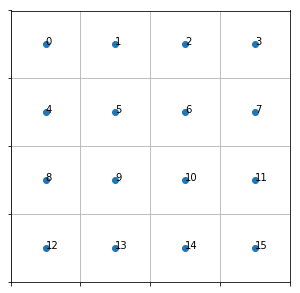

In [ ]:
size = (4,4)
show_anchors(create_grid(size), size)

In [ ]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [ ]:
ratios = [1/2,1,2]
#scales = [1,2**(-1/3), 2**(-2/3)]
scales = [1,2**(1/3), 2**(2/3)]
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse()
anchors = create_anchors(sizes, ratios, scales)

In [ ]:
anchors.size()
#[anc.size() for anc in anchors]

torch.Size([3069, 4])

In [ ]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

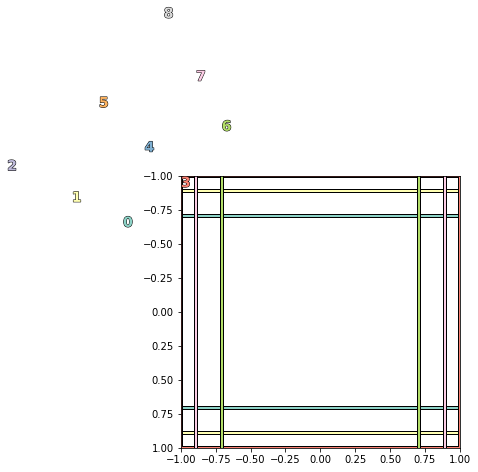

In [ ]:
show_boxes(anchors[-9:])

In [ ]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [ ]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)

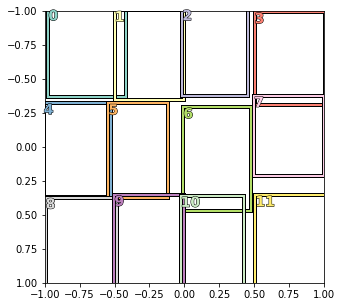

In [ ]:
show_boxes(bboxes)

In [ ]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [ ]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

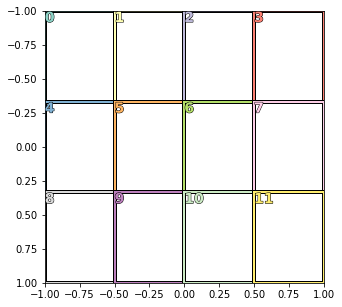

In [ ]:
show_boxes(anchors)

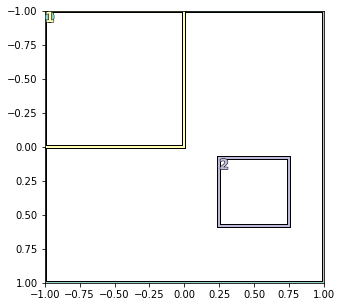

In [ ]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [ ]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [ ]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [ ]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

Manually checked that those are right.

In [ ]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    ious = IoU_values(anchors, targets)
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

Last example

In [ ]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

With anchors very close to the targets.

In [ ]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([-2,  1, -2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

With anchors in the grey area.

In [ ]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [ ]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [ ]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [ ]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [ ]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [ ]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred)
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() == 0: return 0.
        bbox_pred = bbox_pred[bbox_mask]
        bbox_tgt = bbox_tgt[matches[bbox_mask]]
        bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        clas_loss = self._focal_loss(clas_pred, clas_tgt)/bbox_mask.sum()
        return bb_loss + clas_loss
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

Alternative to the L1 smooth loss used in online implementations

In [ ]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        target.div_(target.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

Sketch to test the loss

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios, reg_loss=SigmaL1SmoothLoss())

In [ ]:
LongTensor([[[0,0,64,128,0], [32,64,128,128,1]], [[128,96,256,192,2], [96,192,128,256,3]]]).float().cuda()

tensor([[[  0.,   0.,  64., 128.,   0.],
         [ 32.,  64., 128., 128.,   1.]],

        [[128.,  96., 256., 192.,   2.],
         [ 96., 192., 128., 256.,   3.]]], device='cuda:0')

In [ ]:
tgt_clas = LongTensor([[1,2], [3,4]])
tgt_bbox = FloatTensor([[[0,0,128,64], [64,32,128,128]], [[96,128,192,256], [192,96,256,128]]])
tgt_bbox = tgt_bbox / 128 - 1.
y = [tgt_bbox.cuda(), tgt_clas.cuda()]

In [ ]:
clas = torch.load(PATH/'models'/'tst_clas.pth')
regr = torch.load(PATH/'models'/'tst_regr.pth')
sizes = [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]]
output = [logit(clas), regr, sizes]

In [ ]:
crit(output, *y)

tensor(4.5380, device='cuda:0')

Checking the output

In [ ]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [ ]:
idx = 3
clas_pred,bbox_pred,sizes = output[0][idx].cpu(), output[1][idx].cpu(), output[2]
bbox_tgt, clas_tgt = y[0][idx].cpu(),y[1][idx].cpu()
bbox_tgt, clas_tgt = unpad(bbox_tgt, clas_tgt)

IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
bbox_tgt

NameError: name 'bbox_tgt' is not defined

In [ ]:
anchors = create_anchors(sizes, ratios, scales)
ious = IoU_values(anchors, bbox_tgt)
matches = match_anchors(anchors, bbox_tgt)

NameError: name 'bbox_tgt' is not defined

In [ ]:
ious[-9:]

tensor([[0.4104, 0.0010, 0.0057, 0.0015, 0.0031, 0.0007, 0.0017],
        [0.2637, 0.0007, 0.0043, 0.0009, 0.0020, 0.0006, 0.0011],
        [0.1661, 0.0004, 0.0027, 0.0006, 0.0012, 0.0004, 0.0007],
        [0.4186, 0.0010, 0.0068, 0.0015, 0.0031, 0.0009, 0.0017],
        [0.2637, 0.0007, 0.0043, 0.0009, 0.0020, 0.0006, 0.0011],
        [0.1661, 0.0004, 0.0027, 0.0006, 0.0012, 0.0004, 0.0007],
        [0.2663, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2306, 0.0000, 0.0043, 0.0007, 0.0013, 0.0006, 0.0000],
        [0.1661, 0.0004, 0.0027, 0.0006, 0.0012, 0.0004, 0.0007]])

In [ ]:
(matches==-2).sum(), (matches==-1).sum(), (matches>=0).sum()

(tensor(14), tensor(3055), tensor(0))

In [ ]:
bbox_mask = matches>=0
bbox_pred = bbox_pred[bbox_mask]
bbox_tgt = bbox_tgt[matches[bbox_mask]]
bb_loss = F.smooth_l1_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

In [ ]:
F.smooth_l1_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

tensor(nan, grad_fn=<SmoothL1LossBackward>)

In [ ]:
tst_loss = SigmaL1SmoothLoss()
tst_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

tensor(1.0928)

In [ ]:
crit.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

tensor(1.1044)

In [ ]:
matches.add_(1)
clas_tgt += 1
clas_mask = matches>=0
clas_pred = clas_pred[clas_mask]
clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
clas_tgt = clas_tgt[matches[clas_mask]]

Focal loss

In [ ]:
alpha, gamma, n_classes = 0.25, 2., 6
encoded_tgt = encode_class(clas_tgt, n_classes)
ps = torch.sigmoid(clas_pred)
weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
alphas = encoded_tgt * alpha + (1-encoded_tgt) * (1-alpha)
weights.pow_(gamma).mul_(alphas)
clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum') / bbox_mask.sum()
clas_loss

tensor(1.0782)

Let's look at the objects missclassified.

In [ ]:
clas_pred[clas_tgt.nonzero().squeeze()]

tensor([[-2.2099, -2.8486, -2.0117, -2.1500, -2.8871, -2.7414],
        [-2.0437, -2.7678, -2.4969, -2.9075, -2.5473, -2.3108],
        [-2.0427, -2.1301, -2.9421, -2.4336, -2.1767, -2.7711],
        [-2.4780, -2.2360, -2.3900, -2.7556, -2.4311, -2.2951],
        [-2.4752, -2.7103, -2.9425, -2.8292, -2.8346, -2.0369],
        [-2.8551, -2.9194, -2.0137, -2.7635, -2.6025, -2.7045],
        [-2.5726, -2.3783, -2.9546, -2.6358, -2.9110, -2.8406],
        [-2.4318, -2.1144, -2.5413, -2.8167, -2.4970, -2.8216],
        [-2.5107, -2.2140, -2.4476, -2.0205, -2.7520, -2.6379],
        [-2.5422, -2.0664, -2.8299, -2.4521, -2.9725, -2.2255],
        [-2.3622, -2.8218, -2.3030, -2.7912, -2.7015, -2.4377],
        [-2.6108, -2.0359, -2.5475, -2.2234, -2.4716, -2.9814],
        [-2.3655, -2.0652, -2.6761, -2.8355, -2.8089, -2.3320],
        [-2.1204, -2.2438, -2.0050, -2.6205, -2.5559, -2.4014],
        [-2.7936, -2.5871, -2.9327, -2.7630, -2.4630, -2.0992],
        [-2.2536, -2.2463, -2.3337, -2.4

In [ ]:
F.binary_cross_entropy_with_logits(clas_pred[clas_tgt.nonzero().squeeze()], encoded_tgt[clas_tgt.nonzero().squeeze()], weights[clas_tgt.nonzero().squeeze()], reduction='sum') / bbox_mask.sum()

tensor(0.5566)

They account for half the loss!

## Training

In [ ]:
train_ds, valid_ds = ObjectDetectDataset.from_json(PATH/'train2017', ANNOT_PATH/'train_sample.json', valid_pct=0.2)
data = DataBunch.create(train_ds, valid_ds, path=PATH, ds_tfms=tfms, tfms=imagenet_norm, collate_fn=bb_pad_collate, 
                        num_workers=8, bs=16, size=128, tfm_y=True, padding_mode='zeros', do_crop=False)

In [ ]:
n_classes = 6
encoder = create_body(tvm.resnet50(True), -2)
model = RetinaNet(encoder, n_classes,final_bias=-4) 
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_fn=crit)

In [ ]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

In [ ]:
learn.lr_find()

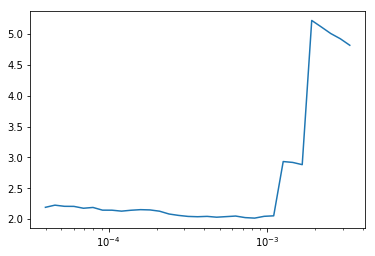

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

Total time: 11:29
epoch  train loss  valid loss
0      1.168157    1.240896    (11:29)



In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')
learn.unfreeze()
lr = 1e-4
lrs = np.array([lr/100,lr/10,lr])
learn.fit_one_cycle(2, lrs)

Total time: 25:23
epoch  train loss  valid loss
0      1.146246    1.434380    (12:39)
1      1.043211    1.432019    (12:43)



In [ ]:
learn.save('sample')

## Inference

In [ ]:
learn.load('sample')

In [ ]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img)

In [ ]:
target[0]

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [-1.0000,  0.6875, -0.0469,  0.8281],
         [-1.0000,  0.5938, -0.4062,  0.7188],
         [-1.0000,  0.5000, -0.6406,  0.6250]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.7812,  0.4375, -0.1562,  0.5781],
         [-1.0000,  0.3281, -0.5156,  0.4688],
         [-1.0000,  0.2812, -0.7812,  0.3594]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0312,  0.3906,  0.1406,  0.6094],
         [ 0.0156,  0.2500,  0.0625,  0.3750]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]

In [ ]:
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.3, classes=None):
    clas_pred,bbox_pred,sizes = output[0][idx].cpu(), output[1][idx].cpu(), output[2]
    anchors = create_anchors(sizes, ratios, scales)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c in zip(bbox_pred, clas_pred.argmax(1)):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=txt)

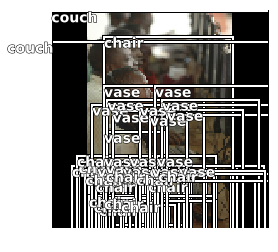

In [ ]:
idx = 1
img = data.valid_ds[idx][0]
classes = data.train_ds.classes
show_preds(img, output, idx, detect_thresh=0.2, classes=classes)

In [ ]:
def nms(boxes, scores, thresh=0.5, keep=100):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort[:keep]], scores[idx_sort[:keep]]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        #pdb.set_trace()
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals <= thresh
        if len(mask_keep.nonzero()) == 0: break
        idx_first = mask_keep.nonzero().min().item()
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

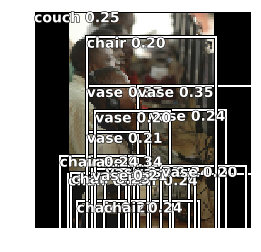

In [ ]:
idx = 1
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.2, classes=data.classes)

## mAP

In [ ]:
def get_true_pos(target, preds, match):
    if len(preds) == 0: return preds.clone()
    tp = target[match] == preds
    matched = []
    for i,m in enumerate(match):
        if tp[i] == 1:
            if m not in matched: matched.append(m)
            else: tp[i] = 0
    return tp

In [ ]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [ ]:
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.05, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, scores, preds = process_output(output, i, detect_thresh)
                to_keep = nms(bbox_pred, scores)
                bbox_pred, preds, scores = bbox_pred[to_keep], preds[to_keep], scores[to_keep]
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                ious = IoU_values(bbox_pred, tgt_bbox)
                max_iou, matches = ious.max(1)
                preds_clas, matches = preds[max_iou >= iou_thresh], matches[max_iou >= iou_thresh]
                if len(preds_clas) > 0:
                    tp = get_true_pos(tgt_clas, preds_clas, matches)
                    tps.append(tp.cpu())
                    clas.append(preds_clas.cpu())
                    p_scores.append(scores[max_iou >= iou_thresh].cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.cat(tps), torch.cat(p_scores), torch.cat(clas)
    fps = 1-tps
    idx = p_scores.argsort()
    tps, fps = tps[idx].cumsum(0), fps[idx].cumsum(0)
    aps = []
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls], fps[clas==cls]
        if len(tps_cls) != 0:
            precision = tps.float() / (tps.float() + fps.float())
            recall = tps.float()  / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [ ]:
L = compute_class_AP(learn.model, learn.data.valid_dl, 6)

In [ ]:
sum(L)/6

0.048504544820688535